# Homework 5

In this homework, you will implement and explore learning using Gaussian mixture generative and linear discriminative models. The goal is both to review the mechanics of fitting the models, and even more so to gain an appreciation of their relative benefits.

We provide you with most of the code required in these parts -- your primary job will be to run the code and inspect and analyze the outcomes. Additionally, you will have to implement the diagonal mixture model you studied in Part I, and the logistic loss function and its derivative for use in the discriminative models.

There are a number of programming **tasks** and **questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

## Imports

In [1]:
import numpy as np
from numpy import array,newaxis,ones,zeros,shape
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, det, inv, pinv, eigvalsh # scipy.linalg is a bit more full-features, includes additional routines,
                                            # and subsumes numpy.linalg.  It's generally its better to use scipy.linalg.
import numpy.random as random
from matplotlib.colors import ListedColormap
np.seterr(over='ignore',under='ignore') # don't issues warnings for overflow and underflow errors

from utils import *

## Preliminaries

We first define `Classifier` as an abstract class that can only be subclassed. We can build on top of this to get the various different classifiers we will eventually be interested in, and this keeps us from having to implement reusable functions like `predict`, `score`, and `error` over and over.

In [2]:
class Classifier:
    def predict_log_proba(self,X):
        # This needs to be implemented by a subclass
        raise NotImplementedError
    def predict(self,X):
        """Returns Bayes Optimal predicted labels"""
        return np.array(self.labels)[np.argmax(self.predict_log_proba(X), 1)]
    def score(self,X,y):
        """Accuracy rate"""
        return np.mean(self.predict(X)==y)
    def error(self,X,y):
        """Error rate (empirical 0/1 error on the given data)"""
        return 1-self.score(X,y)

In particular, we can start by thinking about linear predictor with respect to some feature map.  Although in this notebook we only used linear predictors with respect to affine_phi (defined below), we included also an implementation of a quadratic feature map, both to emphasize that we can use different feature maps, and to encourage you to experiment with it.

In [3]:
def homogeneous_phi(x):
    return x
def affine_phi(x):
    return np.hstack( ( np.ones( (np.size(x,0),1) ) , x ) )
def quad_phi(x):
    return np.hstack( ( np.ones( (np.size(x,0),1) ) , x , x[:,newaxis,:]*x[:,:,newaxis]) )

class LinearClassifier(Classifier):
    """A based class for linear classifiers.

    Uses the weight vector self.w, but this base class does not define self.w.
    It needs to be defined (e.g. learned from data) in a subclass."""
    def __init__(self,phi=affine_phi):
        self.phi=phi
    def predict(self,X):
        return np.sign(self.phi(X)@self.w)

## Generative Modelling

In the generative approach, we assume that the data we receive were generated using some known model, and we then wish to determine the parameters of that model.

Let us first implement the different generative models we will explore. These are implemented in Python using the **object-oriented** paradigm. Familiarize yourself with that if you are not already familiar. We implement several classes that build on top of `GaussianMix` so that we can run various different algorithms. The base class `GaussianMix` also has the ability to generate points from a mixture of Gaussians with means, covariances, and proportions defined while instantiating the class. We use this to generate several of the datasets we later consider.


`GaussianMix` subclasses `Classifier` because we are interested in how that mixture behaves as a classifier. Then, once we learn the appropriate parameters from data, we may wish to compute what that generative model predicts for new points, so `LearnedGaussianMix` subclasses `GaussianMix`. From here, `LDA`, `DiagGM`, `DiagLDA`, etc., all differ in specifically which parameters are learnt and which are assumed, and so they subclass `LearnedGaussianMix`.

### [Task 1] Finish the implementation of DiagGM
**First**, read over the code in the following cells and familiarize yourself with what methods are available and what the different pieces do.

**Second**, fill in the code for DiagGM in the third cell.

In [4]:
def plogdeth(A):
    """For a full-rank Hermitian matrix, return log(det(A)).  If not full-rank, ignore zero eigenvalues."""
    v = eigvalsh(A)
    return np.sum(np.log(v[~np.isclose(v,0)]))
    # first taking the log and then summing is safer and more numerically satble and acurate, as it avoids really big numbers

In [5]:
class GaussianMix(Classifier):
    """Represents a mixture of Gaussians, with one label per Gaussian."""
    def __init__(self,mus=[np.array([-1,0]),np.array([1,0])],Sigmas=1,ps=None,labels=[-1,1]):
            """Instantiate the mixture based on specified parameters"""
            from numbers import Number
            d = len(mus[0]) # the dimensionality
            if isinstance(Sigmas,Number): # A scalar can be passed for Sigmas, indicating a scaled identity covariance
                Sigmas = Sigmas*np.eye(d)
            if isinstance(Sigmas,np.ndarray): # If only a single matrix is passed, it is used as the covariance for all classes
                Sigmas = [Sigmas]*len(labels)
            if ps is None: # default to uniform over the components
                ps = np.array([1/len(labels)]*len(labels))
            self.d = d
            self.mus=mus
            self.Sigmas=Sigmas
            self.ps=ps
            self.labels=labels
    def generate(self,m):
        """Generate m samples from the mixture"""
        y = random.choice(self.labels,p=self.ps,size=m)
        x = np.empty((m,self.d))
        for label,mu,Sigma in zip(self.labels,self.mus,self.Sigmas):
            thism = sum(y==label)
            x[y==label] = random.randn(thism,self.d)@sqrtm(Sigma)+mu
        return x,y

    def predict_log_proba(self,x):
        """Log posteriors.
        Returns logp, where logp[i,j]=log P(labels[j]|x[i,:])"""
        return np.stack([np.log(p) -0.5*np.sum(((x-mu)@pinv(Sigma))*(x-mu),1) -0.5*plogdeth(2*np.pi*Sigma)
                             for p,mu,Sigma in zip(self.ps,self.mus,self.Sigmas)]).T

    ##################################################################################################
    # The following methods are not used in this homework.  They are provided to you to emphasize how
    # the discriminant, and Bayes classifier, for a Gaussian mixture, is linear or quadratic.  We ecnourage
    # you to expriment with these methods and study them
    ##################################################################################################
    def lin_logpost(self):
        """returns b,w, such that log P(labels[i]|x) \propto b[i] + w[i,:]@x"""
        assert allallclose(self.Sigmas)
        Sinv=pinv(self.Sigmas[0])
        mus = array(self.mus)
        b = np.log(self.ps) - 0.5 * sum(mus[:,newaxis,:]*mus[:,:,newaxis]*Sinv,axis=(1,2))
        w = mus@Sinv
        return b,w
    def quad_logpost(self):
        """returns b,w,H such that log P(labels[i]|x)=b[i] + w[i]@x + 0.5*x@H[i]@x"""
        Sinvs = [ pinv(Sigma) for Sigma in self.Sigmas ]
        b = [ np.log(p) - 0.5*mu@Sinv@mu +0.5*plogdeth(Sinv/(2*np.pi)) for p,mu,Sinv in zip(self.ps,self.mus,Sinvs)]
        w = [ mu@Sinv for mu,Sinv in zip(self.mus,Sinvs) ]
        H = [ -S for S in Sinvs]
        return b,w,H
    def lin_pred(self):
        """For two labels, return b,w such the discriminant is b+w@x"""
        bs,ws = self.lin_logpost()
        return bs[1]-bs[0],ws[1]-ws[0]
    def quad_pred(self):
        """For two labels, returns b,w,H such that the discriminant is b+w@x+x@H@x"""
        bs,ws,Hs = self.quad_logpost()
        return bs[1]-bs[0],ws[1]-ws[0],Hs[1]-Hs[0]
    def as_linear_predictor(self):
        """Returns a Linear Predictor (as a LinearClassifier instance) corresponding to the
        Bayes classifier for the mixture, if it is indeed linear."""
        clf = LinearClassifier()
        b,w = self.lin_pref()
        clf.w = np.block([b,w])
        return clf
    def as_quad_pred(self):
        """Returns a Quadratic Predctor (as a LinearClassifier instance over quadratic features)
        corresponding to the Bayes classifier for the mixture."""
        clf = LinearClassifier(phi=quad_phi)
        b,w,H = self.equad_pred()
        clf.w = np.block([b,w,np.flatten(H)])
        return clf

In [34]:
class LearnedGaussianMix(GaussianMix):
    def __init__(self,labels=None):
        '''Create a "blank" Gaussian Mixture, without parameters yet (and hence can't be used).
        Use self.fit(X,y) to fit the parameters to data'''
        self.labels=labels
    def fit(self,Xs,ys):
        if self.labels is None:
            self.labels = np.unique(ys)
        labels = self.labels
        ps=np.mean(ys[:,newaxis]==labels,0)
        mus = [ np.mean(Xs[ys==y,:],0) for y in labels]
        Sigmas = [ np.cov(Xs[ys==y].T,bias=True) for y in labels]
        GaussianMix.__init__(self,mus=mus,Sigmas=Sigmas,ps=ps,labels=labels)
class LDA(LearnedGaussianMix):
    """Covariances matrices constrained to be the same"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        self.Sigmas = [ np.sum( np.array(self.Sigmas) * self.ps[:,newaxis,newaxis],0) ] * len(self.labels)
class DiagGM(LearnedGaussianMix):
    """Covariances matrices constrained to be diagonal"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        #### TASK 1 CODE
        # The best sigmas are exactly the covariance within each set of training samples with same label
        pass
        #### TASK 1 CODE
class DiagLDA(LDA,DiagGM):
    """Covariance matrices constrained to be the same diagonal matrix"""
    pass
class SphericalGM(DiagGM):
    """Covariance matrices constrained to be spherical"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        self.Sigmas=[ np.mean(np.diag(Sigma))*np.eye(self.d) for Sigma in self.Sigmas]
class SphericalLDA(LDA,SphericalGM):
    """Covariance matrices constrained to be the same spherical"""
    pass
class UnitSphericalGM(SphericalLDA):
    """Covariance matrices constrained to be spherical with unit variance, i.e. identity"""
    def fit(self,*args,**kwargs):
        super().fit(*args,**kwargs)
        # going through the LDA and Spherical, or even calculating the covariance, is redundant,
        # but this is subclassed to indicate it has all the properties of them
        self.Sigmas=[ np.eye(self.d) ]*len(self.labels)

## Discriminative Modelling

We will fit discriminative models using Empirical Risk Minimization, i.e. by minimizing the training loss.  To miminmize the loss, we wll use[`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). This function implements many different gradient based optimization methods and defaults to using [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). (It also implements methdods that use only function evaluations, without gradients, as well as second order methods that use also the Hessian, but here we will focus on gradient based methods).  To use ['minimize'], we need to pass it functions returning the objective value and the gradient of the objective value.

We will consider loss functions of the form $\ell(\langle w,\phi(x)\rangle,y)=loss(y\langle w,\phi(x)\rangle)$ for a scalar function $loss$.  In particular, we will use the hinge loss, for which $loss(z)=[1-z]_+$ and the logistic loss, for which $loss(z)=\log(1+e^{-z})$.

### [Task 2] Looking for a great $\beta$ value

You need to complete two parts of this implementation:

1. The computation of training_grad inside the fit() method.

2. The computation of the logistic loss and its derivative in the subclass LogisticReg.  You can use the already implemented HingeReg as a template.

In [8]:
class ERMLinearClassifier(LinearClassifier):
    """Linear predictor trained by minimizing the (regularized) empirical risk, with respect to some loss function.

    This is a base class that does not define which loss function and which regularizer is used---these need to be
    defined in subclasses.  The loss function is defined in terms of a scalar function loss(z) where
    ell(prediction,y)=loss(y*prediction).

    In particular, in order to be used, base classes must define the following methods:
    loss_func(self,z) -> array of the same shape as z, with values loss(z)
    loss_derivative(self,z) -> array the same shape as z, with values loss'(z).

    The regularizer is defined via the methods regularizer(self,w) and its gradient regularizer_grad(self,w).
    In the based class, the regularizer is zero (no regularization).  It can be optionally implemented in a
    base class."""
    def __init__(self,lmb=0,*args,**kwargs):
        """lmb is the regularization tradeoff parameters.  Default lmb=0 for no regularization."""
        super().__init__()
        self.lmb=lmb
    def fit(self,X,y,verbose=False):
        """Fit the linear predictor by minimizing the empirical risk"""
        from scipy.optimize import minimize
        yphiX = y[:,newaxis]*self.phi(X)
        m,d = np.shape(yphiX)
        def training_obj(w):
            # training objective, for the given data, as a function of a predictor w
            return np.mean(self.loss_func(yphiX@w)) + self.lmb * self.regularizer(w)
        def training_grad(w):
            #### TASK 2 CODE
            # gradient of training_obj with respect to w
            return np.mean(self.loss_derivative(yphiX@w)) + self.lmb * self.regularizer_grad(w)
            # you will want to use self.loss_derivative and self.regularizer_grad
            #### TASK 2 CODE
        minimization = minimize(training_obj, zeros(d), jac=training_grad)
        self.w = minimization.x
    def regularizer(self,w):
        return 0
    def regularizer_grad(self,w):
        return np.zeros(len(w))


class HingeReg(ERMLinearClassifier):
    def loss_func(self,z):
        return np.maximum(0,1-z)
    def loss_derivative(self,z):
        return -1*(z<1)

class LogisticReg(ERMLinearClassifier):
    def loss_func(self,z):
        #### TASK 2 CODE
        return np.log(1 + np.exp(-z))
        #### TASK 2 CODE
    def loss_derivative(self,z):
        #### TASK 2 CODE
        return -1/(np.exp(z) + 1)
        #### TASK 2 CODE


class L2RegLinear(ERMLinearClassifier):
    def regularizer(self,w):
        return np.sum(w**2)/2
    def regularizer_grad(self,w):
        return w


class L1RegLinear(ERMLinearClassifier):
    def regularizer(self,w):
        return np.sum(np.abs(w))
    def regularizer_grad(self,w):
        return np.sign(w)


class LogisticL2Reg(LogisticReg,L2RegLinear):
    pass


class HingeL2Reg(HingeReg,L2RegLinear):
    pass


class LogisticL1Reg(LogisticReg,L1RegLinear):
    pass


class HingeL1Reg(HingeReg,L1RegLinear):
    pass

## Data Distributions

Let us now take a look at the different data distributions we will explore in this assignment. The distributions are implemented as functions that take an input m and return m iid draws from the dsitribution.  For each type of distribution we provide a possibly high dimensional variant, `source_k`, and a two dimensional variant `source_k_2d` that is easier to plot and interogate.  You should look at the catter plots of the 2D examples to to understand what the source distributions looks like. The scatter plot function takes in some data, `X, y`, plots it on a 2D axis, and colors the points according to the labels.

The source distributinos are created using functions that take parameters (such as the seperation between components or number of dimensions) and return the sampling functios.  You can try different variants of these source distributions.

### Mixture of Spherical Gaussians

This distribution is a mixture of two Gaussians with unit spherical covariance. Namely:
$$
\mathcal{D} \sim \frac 12 \mathcal{N}\left( \mu_+, I_d  \right) + \frac 12 \mathcal{N}\left( \mu_-, I_d  \right)\,,
$$
and $\mu_- = -\mu_+\,.$

In [9]:
def spherical_Gaussians(sep,d):
    return GaussianMix( mus=(np.block( [ -sep/2,zeros(d-1) ] ),
                             np.block( [  sep/2,zeros(d-1) ] ) ) ).generate

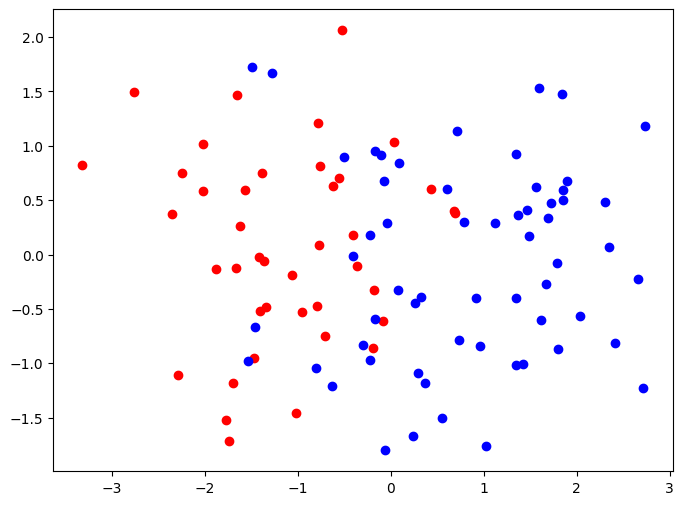

In [10]:
source_1 = spherical_Gaussians(sep=2,d=50)
source_1_2d = spherical_Gaussians(sep=2,d=2)

scatter_plot(*(source_1_2d(100)))

### Skewed Gaussians

This distribution is a mixture of two Gaussians, with means $\pm \mu$ and covariance $\Sigma = \begin{pmatrix} (s+1) & s & ... & s \\
s & (s+1) & ... & s \\
\vdots \\
s & s & ... & (s+1)\end{pmatrix}$ where $s$ is a skewness parameters.

In [11]:
def skewed_Gaussians(skew,sep,dim=2):
    from math import sqrt
    sqrtSigma = np.eye(dim)+skew*np.ones((dim,dim))
    dist = sep/sqrt(inv(sqrtSigma)[0,0]) # This is an incorrect calculation, but
         # is retained here due to a bug in the initial release of the homework, and so as to
         # generate the same distributino
    trueSigma = sqrtSigma @ sqrtSigma.T
    trueskew = trueSigma[0,1]/(trueSigma[0,0]-trueSigma[0,1])
    truesep = dist*sqrt(inv(trueSigma)[0,0])
    print(f'Actually using skew={trueskew} and sep={truesep}')
    mu = np.block( [ dist/2 , np.zeros(dim-1)] )
    return GaussianMix(mus=(mu, -mu), Sigmas=trueSigma ).generate

Actually using skew=2020.0 and sep=2.9996092579797473
Actually using skew=220.0 and sep=2.9343465389060186


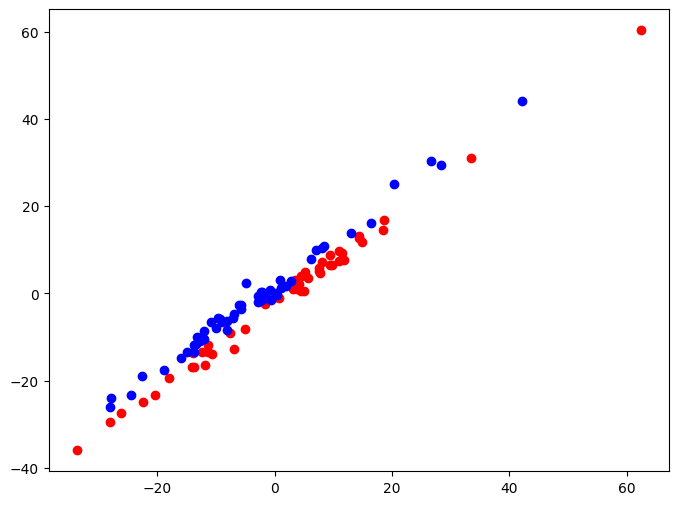

In [12]:
source_2 = skewed_Gaussians(skew=10,sep=3,dim=20)
source_2_2d = skewed_Gaussians(skew=10,sep=3)
scatter_plot(*(source_2_2d(100)))

### Horizontal-Vertical

This distribution is a mixture of two Gaussians, one with larger variance in the horizontal direction and the other with larger variance in the vertical direction, placed such that there is some overlap.

In [13]:
def horizontal_vertical(sep):
    return GaussianMix(mus=(np.array( [ sep,0] ),
                            np.array( [  0,0] ) ),
                       Sigmas=( np.diag([6,0.2])**2 , np.diag([0.7,10])**2 ) ).generate

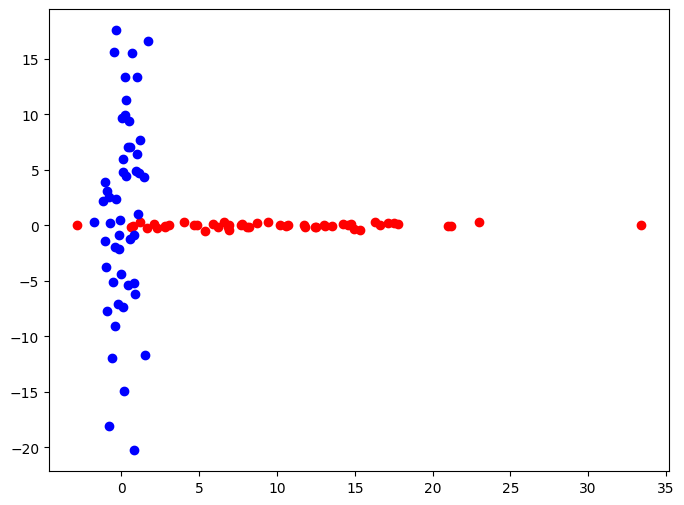

In [14]:
source_3 = horizontal_vertical(sep=10)

scatter_plot(*(source_3(100)))

### Heavy-Tailed

This distribution has three kinds of points: one where each component is generated from a heavy-tailed distribution and has positive label, one where each componenent is the negative of samples generated from a heavy-tailed distribution and has negative label, and finally, a small cluster of positive points placed in the negative region. The proportion of points that are in this cluster is set by the parameter $b\,,$ which is set to 0 for `source_4` and 0.1 for `source_5`.

There are many different definitions of "heavy-tailed," but the relevant one here is that the variance is infinite. The components are drawn from a Pareto distribution, which has density:
$$
f_\text{Pareto}(x) = \frac{1}{x^2}
$$

In [15]:
def ht_data(d=10, p=0.5, b=0.1):
    def ht_data_params(n):
        n_true_pts = np.random.binomial(n, 1-b)
        n_p = np.random.binomial(n_true_pts, p)
        X_p = 0.05+np.random.pareto(1, size=(d, n_p))
        X_n = -0.05-np.random.pareto(1, size=(d, n_true_pts - n_p))
        X_clust = np.random.multivariate_normal(mean=np.block([-20, -5*np.ones((d-1,))]), cov=np.eye(d), size=(n-n_true_pts,)).T
        y = np.hstack((np.ones(n_p,), -1*np.ones(n_true_pts-n_p), np.ones(n - n_true_pts)))
        x = np.hstack((X_p, X_n, X_clust))
        idxs = np.random.permutation(n)
        return x[:, idxs].T, y[idxs]

    return ht_data_params

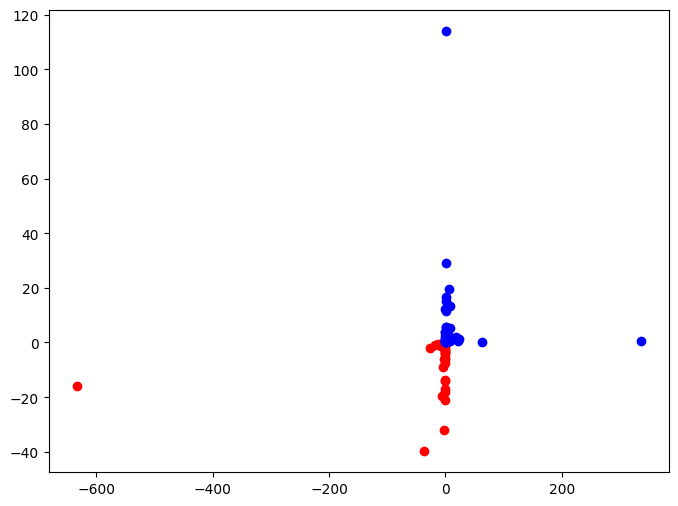

In [16]:
source_4 = ht_data(b=0)
source_4_2d = ht_data(d=2, b=0)

scatter_plot(*(source_4_2d(100)))

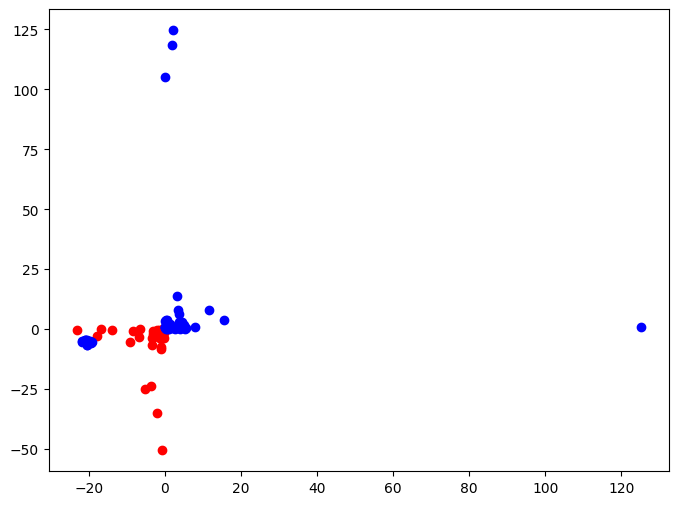

In [17]:
source_5 = ht_data()
source_5_2d = ht_data(d=2)

scatter_plot(*(source_5_2d(100)))

In order to understand how one particular method performs on one specific 2D data distribution, we can plot the decision boundary to see how it compares to the actual distribution.

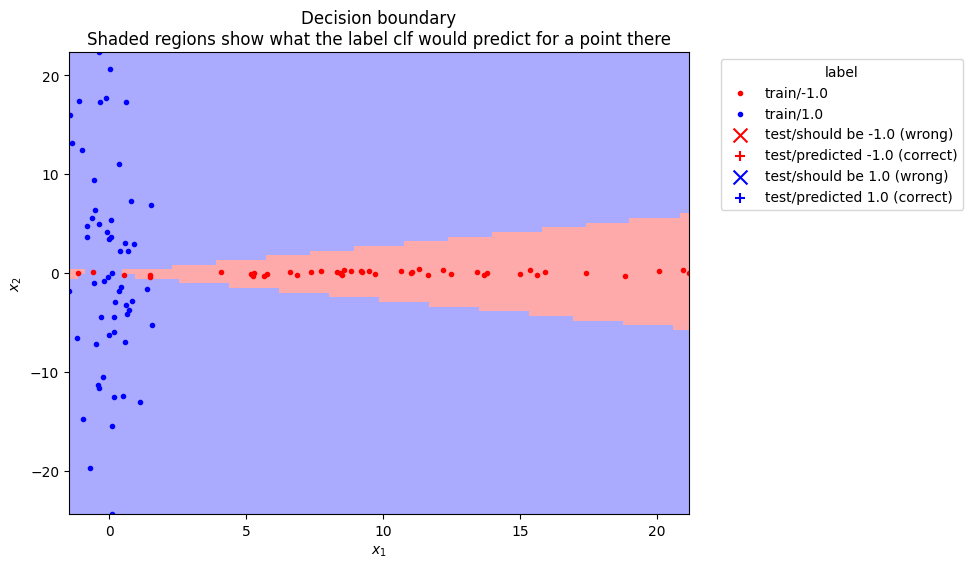

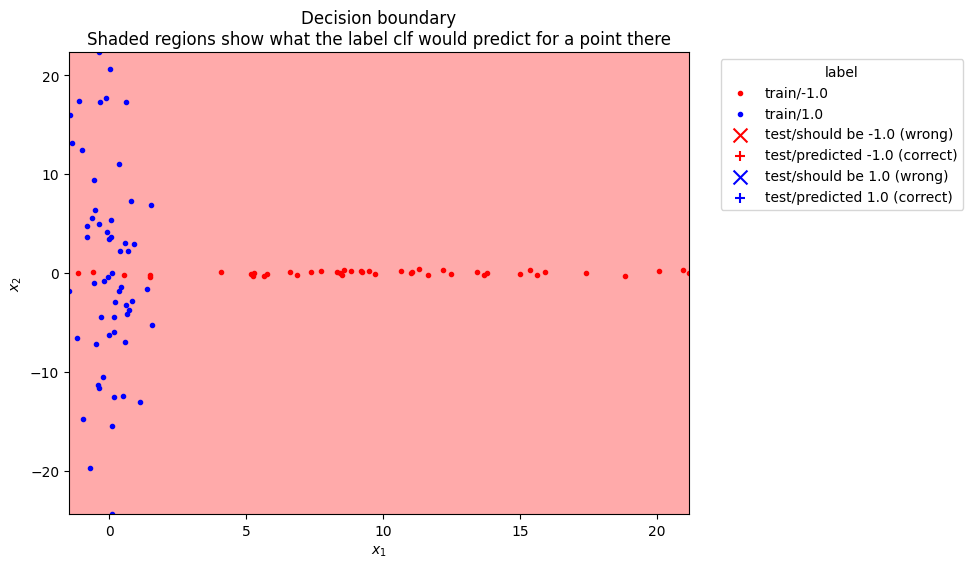

In [18]:
x,y = horizontal_vertical(sep=10)(100)
dgm = DiagGM()
dgm.fit(x,y)
linh = HingeReg()
linh.fit(x,y)
plot_decision_boundary(dgm,x,y)
plot_decision_boundary(linh,x,y)

However, to benchmark how these methods do on high-dimensional data, what we are really interested in is sample efficiency -- how much data does a given method require to succeed on a given dataset?

## Summary of Methods
There are five methods we want to explore in this homework:
* `UnitSphericalGM()`: This method fits the means but assumes a unit spherical covariance.
* `DiagGM()`: This method fits means and allows for a diagonal covariance, where different components have different covariances.
* `LDA()`: This method runs Linear Discrimnant Analysis.
* `LogisticReg()`: This method minimizes the Logistic Loss.
* `HingeReg()`: This method minimizes the Hinge Loss.

## Comparisons

Equipped with the desired code, let us now run some experiments to see how well different approaches perform on different datasets. Below we provide a function that allows you to try all the previously-described methods on a give source distribution (that is, on data generated by some provided sampler).

In [19]:
methods = { 'unispherical':UnitSphericalGM(), 'diag':DiagGM(), 'LDA':LDA(), 'logistic':LogisticReg(), 'hinge':HingeReg()}

def try_methods_on_data(datagen, methods=methods, max_train=300, test_size=1000, min_train=10, num_sizes=20,num_rep=10):
    test_x,test_y = datagen(test_size)
    train_sizes = np.linspace(min_train,max_train,num_sizes).astype(int)
    errors = { name:zeros(len(train_sizes)) for name in methods }
    for i,train_size in enumerate(train_sizes):
        for r in range(num_rep):
            train_x,train_y = datagen(train_size)
            for name,method in methods.items():
                method.fit(train_x,train_y)
                errors[name][i]+=method.error(test_x,test_y)/num_rep
    for name,errs in errors.items():
        plt.plot(train_sizes, errs, label=name)
    plt.legend()
    plt.xlabel("sample size")
    plt.ylabel("error")
    plt.show()
    return errors


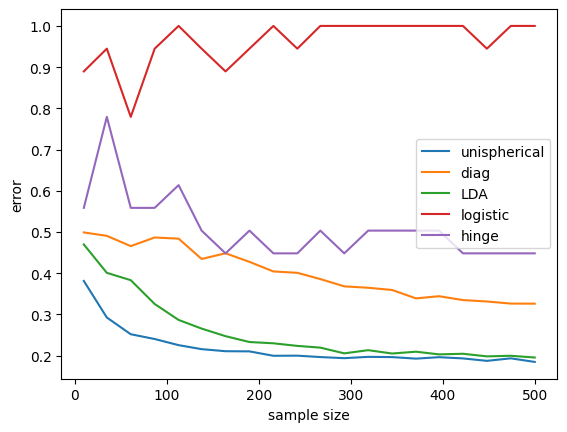

{'unispherical': array([0.381 , 0.2923, 0.2517, 0.2401, 0.2252, 0.2155, 0.2105, 0.2101,
        0.1994, 0.1997, 0.1963, 0.1936, 0.1968, 0.1962, 0.1925, 0.196 ,
        0.193 , 0.1871, 0.1932, 0.1845]),
 'diag': array([0.4988, 0.4905, 0.4656, 0.4865, 0.4837, 0.4344, 0.4482, 0.4274,
        0.4041, 0.4008, 0.3856, 0.3679, 0.3645, 0.3591, 0.3387, 0.344 ,
        0.3346, 0.3312, 0.3261, 0.3259]),
 'LDA': array([0.4696, 0.4007, 0.3829, 0.3251, 0.2864, 0.2654, 0.247 , 0.2328,
        0.2297, 0.2234, 0.2192, 0.2053, 0.213 , 0.2049, 0.2093, 0.2028,
        0.2043, 0.198 , 0.1994, 0.1952]),
 'logistic': array([0.8896, 0.9448, 0.7792, 0.9448, 1.    , 0.9448, 0.8896, 0.9448,
        1.    , 0.9448, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
        1.    , 0.9448, 1.    , 1.    ]),
 'hinge': array([0.5584, 0.7792, 0.5584, 0.5584, 0.6136, 0.5032, 0.448 , 0.5032,
        0.448 , 0.448 , 0.5032, 0.448 , 0.5032, 0.5032, 0.5032, 0.5032,
        0.448 , 0.448 , 0.448 , 0.448 ])}

In [20]:
try_methods_on_data(source_1, min_train=10, max_train=500)

source 1


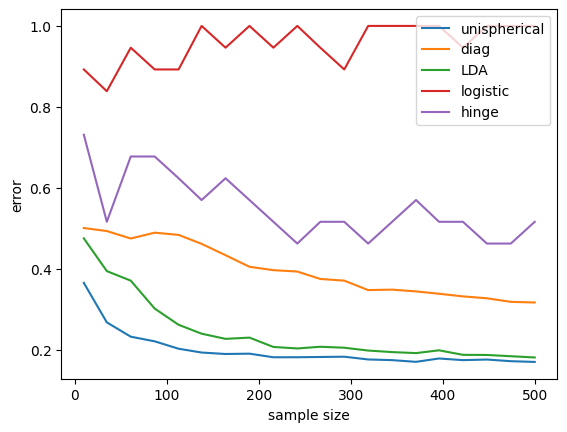

{'unispherical': array([0.3648, 0.2671, 0.2318, 0.2203, 0.202 , 0.1926, 0.189 , 0.1898,
       0.1809, 0.181 , 0.1816, 0.1823, 0.1755, 0.1738, 0.1696, 0.1779,
       0.1738, 0.1753, 0.1712, 0.1694]), 'diag': array([0.5004, 0.4929, 0.4745, 0.4889, 0.4834, 0.4613, 0.4332, 0.4046,
       0.3962, 0.3928, 0.3745, 0.3703, 0.347 , 0.3481, 0.3437, 0.3379,
       0.3314, 0.3267, 0.3179, 0.3163]), 'LDA': array([0.4748, 0.3939, 0.3703, 0.3013, 0.2612, 0.2392, 0.2264, 0.2295,
       0.2064, 0.2027, 0.2069, 0.2045, 0.1975, 0.1937, 0.1912, 0.1981,
       0.1869, 0.1866, 0.1835, 0.1804]), 'logistic': array([0.8924, 0.8386, 0.9462, 0.8924, 0.8924, 1.    , 0.9462, 1.    ,
       0.9462, 1.    , 0.9462, 0.8924, 1.    , 1.    , 1.    , 1.    ,
       0.9462, 1.    , 1.    , 1.    ]), 'hinge': array([0.731 , 0.5158, 0.6772, 0.6772, 0.6234, 0.5696, 0.6234, 0.5696,
       0.5158, 0.462 , 0.5158, 0.5158, 0.462 , 0.5158, 0.5696, 0.5158,
       0.5158, 0.462 , 0.462 , 0.5158])}
source 2


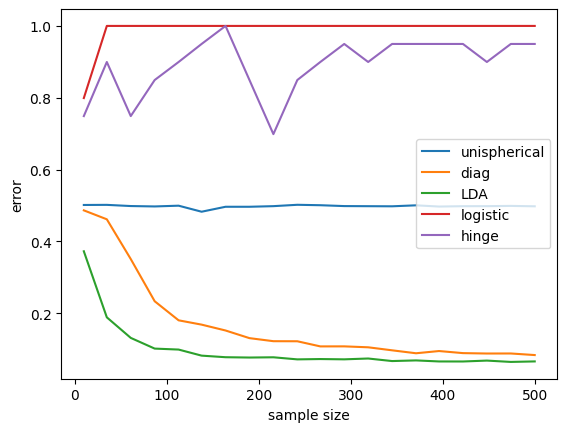

{'unispherical': array([0.5016, 0.5019, 0.4986, 0.4975, 0.4996, 0.4828, 0.4966, 0.4966,
       0.4983, 0.5021, 0.5009, 0.4985, 0.4982, 0.4979, 0.5006, 0.4972,
       0.4982, 0.4983, 0.499 , 0.4979]), 'diag': array([0.4866, 0.4617, 0.3511, 0.2336, 0.1805, 0.1685, 0.1522, 0.1309,
       0.1224, 0.1222, 0.1079, 0.108 , 0.1054, 0.097 , 0.0888, 0.095 ,
       0.0892, 0.0881, 0.0882, 0.0838]), 'LDA': array([0.3727, 0.1888, 0.1316, 0.1018, 0.0991, 0.0822, 0.0778, 0.0769,
       0.0776, 0.0718, 0.0727, 0.0719, 0.0742, 0.0671, 0.0689, 0.066 ,
       0.0659, 0.0684, 0.0647, 0.0661]), 'logistic': array([0.7992, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    ]), 'hinge': array([0.749 , 0.8996, 0.749 , 0.8494, 0.8996, 0.9498, 1.    , 0.8494,
       0.6988, 0.8494, 0.8996, 0.9498, 0.8996, 0.9498, 0.9498, 0.9498,
       0.9498, 0.8996, 0.9498, 0.9498])}
source 3


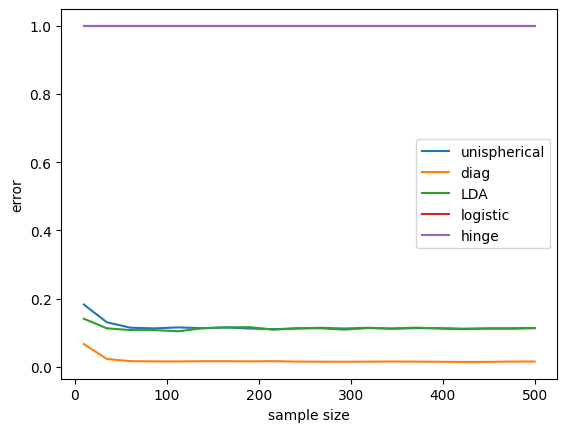

{'unispherical': array([0.1827, 0.1306, 0.1145, 0.1128, 0.1156, 0.1133, 0.1155, 0.1124,
       0.1105, 0.1125, 0.1143, 0.1122, 0.1144, 0.1115, 0.1135, 0.1131,
       0.1117, 0.1126, 0.1126, 0.114 ]), 'diag': array([0.0666, 0.023 , 0.0165, 0.0159, 0.0157, 0.0164, 0.0164, 0.016 ,
       0.0165, 0.0152, 0.015 , 0.0148, 0.0151, 0.0156, 0.0151, 0.0148,
       0.0143, 0.0144, 0.0153, 0.0155]), 'LDA': array([0.1411, 0.1129, 0.1077, 0.1076, 0.1043, 0.1126, 0.1154, 0.1163,
       0.1088, 0.113 , 0.113 , 0.1091, 0.1137, 0.1124, 0.1148, 0.1125,
       0.1105, 0.1121, 0.1119, 0.1133]), 'logistic': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.]), 'hinge': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])}
source 4


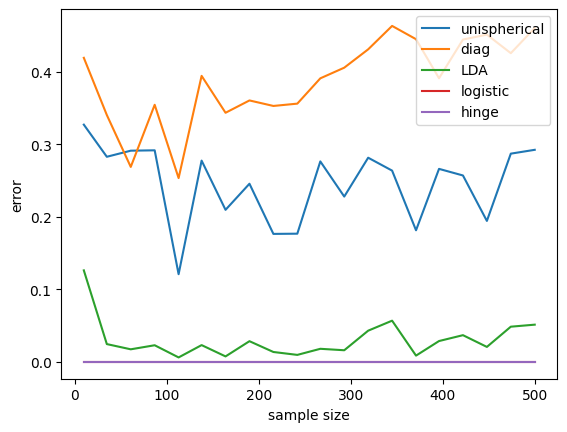

{'unispherical': array([0.3273, 0.283 , 0.2914, 0.2919, 0.121 , 0.2777, 0.2098, 0.2458,
       0.1766, 0.1769, 0.2766, 0.2281, 0.2817, 0.2639, 0.1816, 0.2663,
       0.2572, 0.1945, 0.2873, 0.2926]), 'diag': array([0.4195, 0.3406, 0.269 , 0.3547, 0.2536, 0.3946, 0.3437, 0.3607,
       0.3531, 0.3563, 0.3912, 0.4059, 0.4312, 0.4635, 0.4452, 0.3913,
       0.4447, 0.4515, 0.4259, 0.4606]), 'LDA': array([0.1263, 0.0246, 0.0174, 0.023 , 0.0062, 0.0232, 0.0076, 0.0286,
       0.0137, 0.0097, 0.0181, 0.0161, 0.0431, 0.0569, 0.0087, 0.0288,
       0.0369, 0.0207, 0.0486, 0.0514]), 'logistic': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'hinge': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}
source 5


/var/folders/48/k67vwzh91m730gsww79dstgc0000gn/T/ipykernel_270/3345898772.py:4: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(v[~np.isclose(v,0)]))


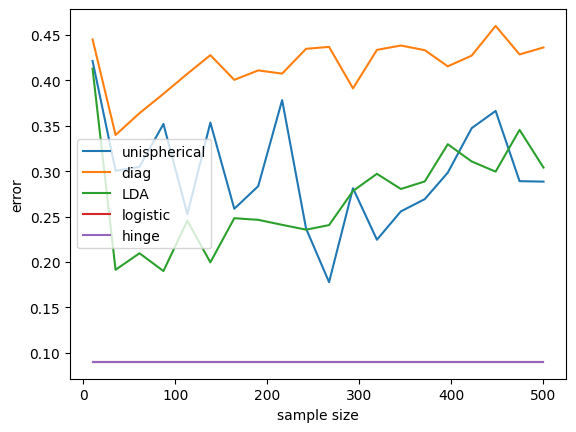

{'unispherical': array([0.4215, 0.3005, 0.3049, 0.3521, 0.2527, 0.3536, 0.2587, 0.2836,
       0.3784, 0.2369, 0.1779, 0.2813, 0.2246, 0.2558, 0.2693, 0.2985,
       0.3475, 0.3665, 0.2891, 0.2886]), 'diag': array([0.4452, 0.34  , 0.364 , 0.3853, 0.4074, 0.4279, 0.4007, 0.4111,
       0.4076, 0.4349, 0.437 , 0.3913, 0.4337, 0.4385, 0.4334, 0.4156,
       0.4274, 0.4601, 0.4287, 0.4364]), 'LDA': array([0.413 , 0.1915, 0.2097, 0.1901, 0.2455, 0.1997, 0.2483, 0.2465,
       0.241 , 0.2357, 0.2407, 0.2783, 0.2972, 0.2805, 0.2888, 0.3298,
       0.3108, 0.2996, 0.3456, 0.3041]), 'logistic': array([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]), 'hinge': array([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09])}


In [22]:
for i, d in enumerate([source_1, source_2, source_3, source_4, source_5]):
    print("source", i+1)
    print(try_methods_on_data(d, min_train=10, max_train=500))

fitting DiagGM
[array([[241.96362946, 241.62736859],
       [241.62736859, 243.38535074]]), array([[222.37285046, 221.52805165],
       [221.52805165, 222.43248356]])]
fitting DiagGM
[array([[36.63382957,  0.15821936],
       [ 0.15821936,  0.03729578]]), array([[  0.49575953,  -0.50664363],
       [ -0.50664363, 110.98041351]])]


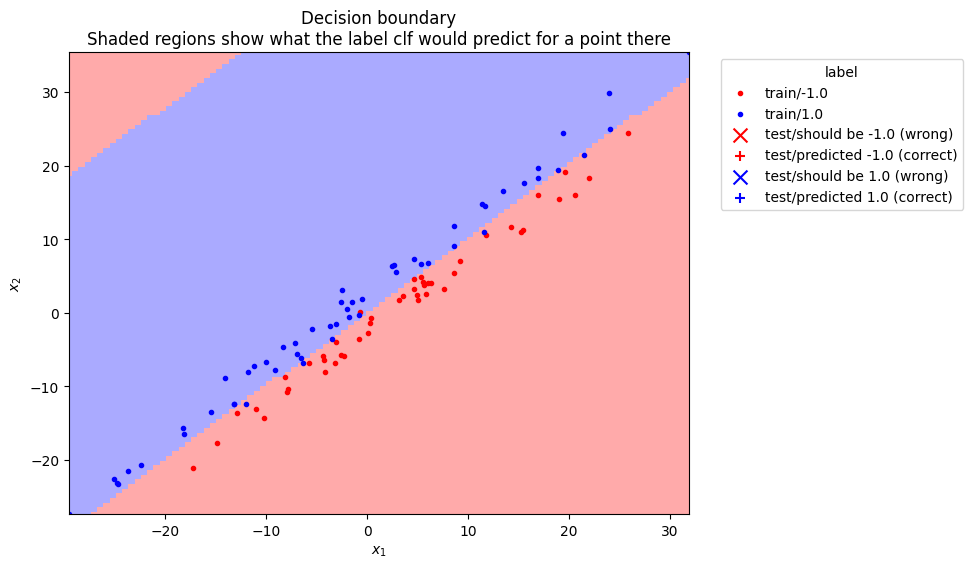

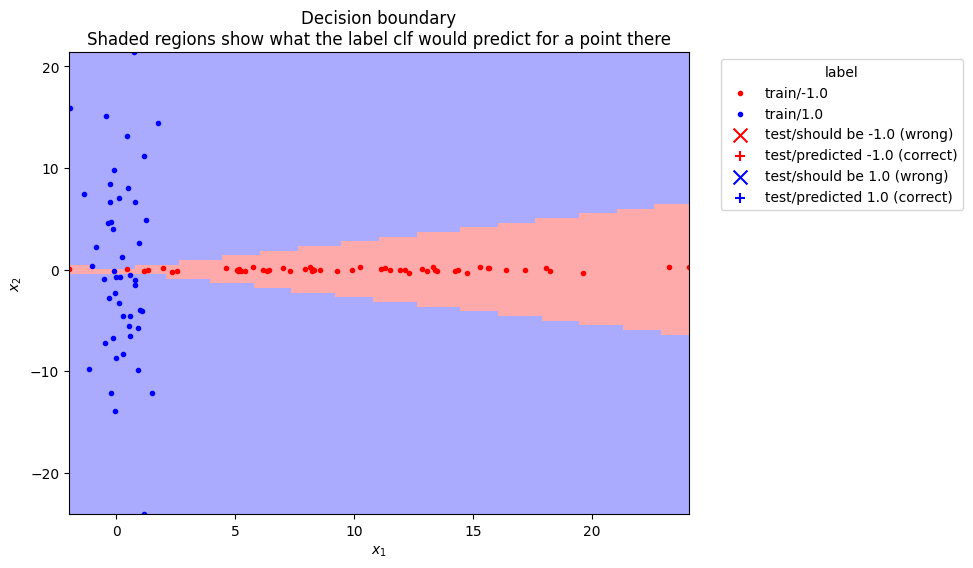

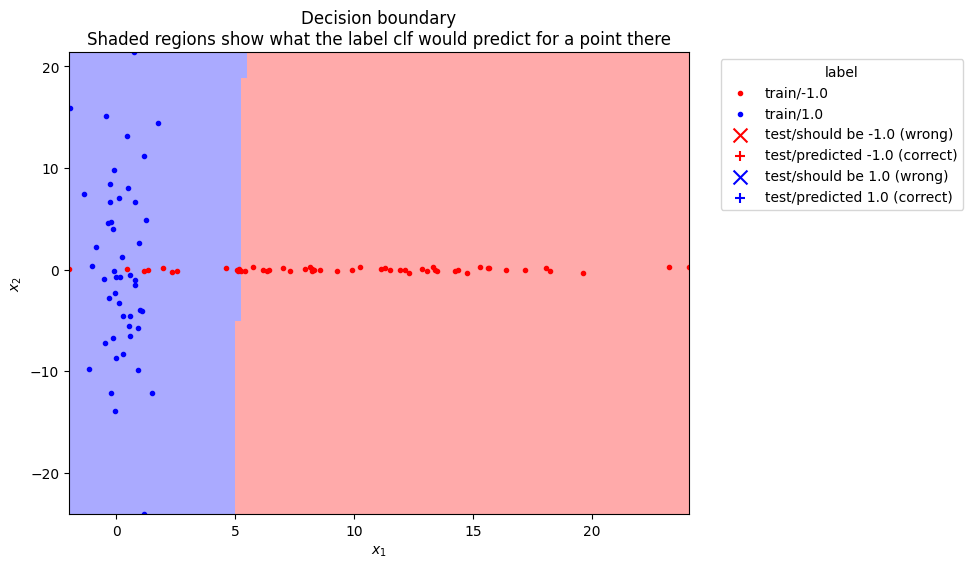

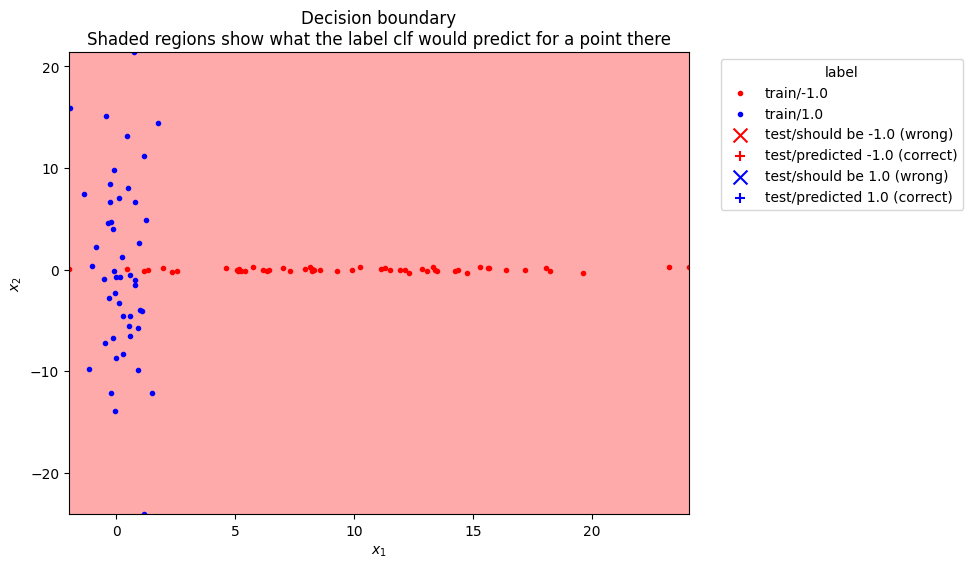

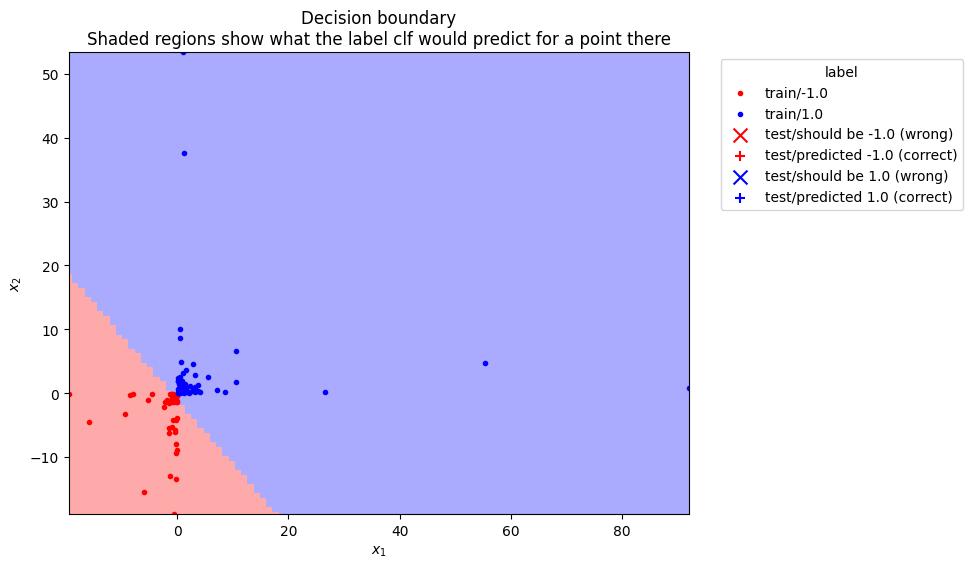

In [32]:

diaggmclf = DiagGM()
ldaclf = LDA()
hingeclf = HingeReg()
X_train, y_train = source_2_2d(500)
X_test, y_test = source_2_2d(100)
diaggmclf.fit(X_train, y_train)
plot_decision_boundary(diaggmclf, X_test, y_test)

X_train, y_train = source_3(500)
X_test, y_test = source_3(100)
diaggmclf.fit(X_train, y_train)
plot_decision_boundary(diaggmclf, X_test, y_test)

ldaclf.fit(X_train, y_train)
plot_decision_boundary(ldaclf, X_test, y_test)

hingeclf.fit(X_train, y_train)
plot_decision_boundary(hingeclf, X_test, y_test)

X_train, y_train = source_4_2d(300)
X_test, y_test = source_4_2d(100)
hingeclf.fit(X_train, y_train)
plot_decision_boundary(hingeclf, X_test, y_test)

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

For each of `source_1`, `source_2`, `source_3`, `source_4`, `source_5`:
* Run `try_methods_on_data` to investigate how the different methods perform on them. By default, it investigates training sets of sizes 10 to 300. However, you should make sure to adjust this range for each source distribution to understand what is happening. You may also need to adjust num_rep.
* In a couple sentences, explain why you get the behavior that you get. Discuss the behavior of the method with small $m$, large $m$, and when $m\rightarrow\infty$. Compare to the Bayes Error. It might be useful and insightful to `plot_decision_boundary` on some specific training set sizes and methods. You can include some of these plots in your explanation. <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer:

On source_1, the spherical Gaussian data, of course the unispherical method would work well, while LDA, requiring all covariance matrices to be the same, trails closely behind as the spherical Gaussian data do have equal covariance matrices.

On source_2, the skewed Guassian data, due to the skew, the unispherical Gaussian no longer works well, while LDA continues to work well since it is flexible to all equal covariance matrices (as seen above)

On source_3, the horizontal-vertical data, the hinge classifier, not having a bias term and can therefore only draw a decision boundary through the origin, completely misses the correct decision boundary. (as seen above)

On source_4 and _5, the HingeReg works great, as the data is linearly separable or almost linearly separable (as seen above)

As for the behavior of the methods for various values of $m$, I see that generally if there is no hope of fitting in the first place (e.g. hingeclf on horizontal-vertical data), then as $m \to \infty$, the loss either doesn't decrease or fluctuate violently in a high value. However, if there is some hope of fitting, such as for LDA/DiagGM on unispherical/skewed Gaussian, or even horizontal-vertical (though the distribution is wrong but the decision boundary is good enough), then the loss would decrease to some asymptote as $m \to \infty$.


</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 3] Play with a real dataset

We will again use the Spam dataset, which should already be familiar with throughout Homework 1 to 3.
We use the bag-of-word vectorization function implemented in HW2 to convert raw text into feature vectors. This function is equivalant to $\phi(\cdot)$ in problem 2(c) of the written homework.

In this task, please use the 5 methods compared in the previous question to train generative and discriminative classifiers on the vectorized Spam dataset, and report the error on the test set.

In [35]:
import os

m = 3000
Xr, yr = read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))
Xr, yr = Xr[:m], yr[:m]

spamdata = TrainAndTestData(*create_split(Xr, yr, 0.9))
Vectorizer = SMS_Vectorizer(spamdata.X_train, d=300)
vectorized_data = TrainAndTestData(Vectorizer.vectorize(spamdata.X_train), spamdata.y_train, Vectorizer.vectorize(spamdata.X_test), spamdata.y_test)

#### TASK 3 CODE
methods = { 'unispherical':UnitSphericalGM(), 'diag':DiagGM(), 'LDA':LDA(), 'logistic':LogisticReg(), 'hinge':HingeReg()}

errors = { name: None for name in methods }
for name, method in methods.items():
    method.fit(vectorized_data.X_train, vectorized_data.y_train)
    errors[name] = method.error(vectorized_data.X_test, vectorized_data.y_test)

print(errors)

#### TASK 3 CODE

{'unispherical': 0.10333333333333339, 'diag': 0.08999999999999997, 'LDA': 0.036666666666666625, 'logistic': 1.0, 'hinge': 1.0}


<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 2]</h4>

What method have better performance on the Spam dataset? In general, do generative methods or discriminative methods have better performance? Does the trend on real data align with what you observed on synthetic data in Question 1? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: The order goes, from best to worst, LDA, Diagonal, Unispherical, Logistic, Hinge. Generative methods have better performance. It then suggests that the real data looks more like source_2 or source_1, than source_4/5.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

Note that, in this task we work on the bag-of-word fectures such that the classifier classes defined earlier can be directly used.
However, it is more common for **text generative models** to directly model the probability distribution of text documents instead of the feature vectors. For example, modern Large-Language Models (LLMs) decompose the probability of a text document $\mathcal{X} = x_1 x_2 x_3 ... x_n$ (where $x_i$ can be smaller written units such as a word or a letter, etc) into a product of posterior probabilities:
$$
P_{\theta}(\mathcal{X}) = P_{\theta}(x_1) P_{\theta}(x_2|x_1) P_{\theta}(x_3|x_1 x_2) ... P_{\theta}(x_n|x_1 ... x_{n-1})
$$
where $\theta$ are model parameters. Instead of the simple Gaussian mixture model introduced before, we usually use other methods to model the probability $P_{\theta}(x_i|\cdot)$ in modern text generative models -- one of the reason is that text are discrete units, not continuous-valued data!

# Summary

Statistician George Box famously said that, "All models are wrong, but some are useful." You've seen some of that for yourself here -- there are certain settings in which specifying the model a certain way allows us to learn with higher accuracy / better generalization, and other settings in which a different specification of the model is better. Even within the landscape of modern machine learning, we've moved away from generative models for certain kinds of tasks (image classification, image segmentation, etc). However, for other problems, we have well-understood and well-specified models that do help us better make sense of what is going on when we receive new data. The field of inverse problems seeks to identify appropriate values for parameters based on a known generative model. While we will not discuss this further in our class, there are classes available at UChicago to study this topic further. Here are some papers that consider generative approaches:

* [Can one hear the shape of a drum?](https://eclass.uoa.gr/modules/document/file.php/MATH379/2.%20%CE%86%CF%81%CE%B8%CF%81%CE%B1%3A%20American%20Mathematical%20Monthly/Can%20one%20hear%20the%20shape%20of%20a%20drum.pdf)

* [Model-Based Estimation of Respiratory Parameters from Capnography, with Application to Diagnosing Obstructive Lung Disease](https://dspace.mit.edu/bitstream/handle/1721.1/134854/07915749.pdf?sequence=2&isAllowed=y)